In [1]:
import numpy as np
import pandas as pd
from statsmodels.sandbox.regression.gmm import IV2SLS 
from statsmodels.regression.linear_model import OLS
from linearmodels.system.model import SUR
from sklearn import preprocessing
import statsmodels.api as sm

In [91]:
data = pd.read_excel('c:/Users/Pongo/Downloads/data iklim/laporan_iklim_harian januari 2023 - juli 2024.xlsx')

data

,Tanggal,Tn,Tx,Tavg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,RH_avg
0,01-01-2023,22.4,27.2,25.1,0.1,2.7,6.0,300.0,4.0,NW,69.0
1,02-01-2023,21.8,30.8,24.7,1.6,2.1,7.0,180.0,2.0,C,78.0
2,03-01-2023,20.3,30.0,24.6,4.4,2.7,5.0,320.0,2.0,SE,78.0
3,04-01-2023,20.2,30.9,25.4,6.2,5.1,4.0,250.0,2.0,S,74.0
4,05-01-2023,21.2,30.0,25.2,0.0,7.7,6.0,180.0,2.0,S,76.0
...,...,...,...,...,...,...,...,...,...,...,...
550,04-07-2024,21.8,26.8,23.9,8888.0,1.5,3.0,220.0,1.0,C,87.0
551,05-07-2024,20.0,29.6,25.3,NaN,1.5,5.0,100.0,2.0,E,73.0
552,06-07-2024,19.4,28.4,25.3,0.0,10.4,5.0,100.0,3.0,E,72.0
553,07-07-2024,20.4,29.4,25.6,0.0,7.3,5.0,70.0,1.0,C,72.0


In [92]:
data = data.drop(['Tanggal','Tx','RR','ddd_x'], axis=1)

le = preprocessing.LabelEncoder()
le.fit(data.ddd_car)
data['ddd_car'] = le.transform(data.ddd_car)

for col in data:
    data[col] = data[col].fillna(data[col].mean())

data

,Tn,Tavg,ss,ff_x,ff_avg,ddd_car,RH_avg
0,22.4,25.1,2.7,6.000000,4.000000,3,69.0
1,21.8,24.7,2.1,7.000000,2.000000,0,78.0
2,20.3,24.6,2.7,5.000000,2.000000,5,78.0
3,20.2,25.4,5.1,4.000000,2.000000,4,74.0
4,21.2,25.2,7.7,6.000000,2.000000,4,76.0
...,...,...,...,...,...,...,...
550,21.8,23.9,1.5,3.000000,1.000000,0,87.0
551,20.0,25.3,1.5,5.000000,2.000000,1,73.0
552,19.4,25.3,10.4,5.000000,3.000000,1,72.0
553,20.4,25.6,7.3,5.000000,1.000000,0,72.0


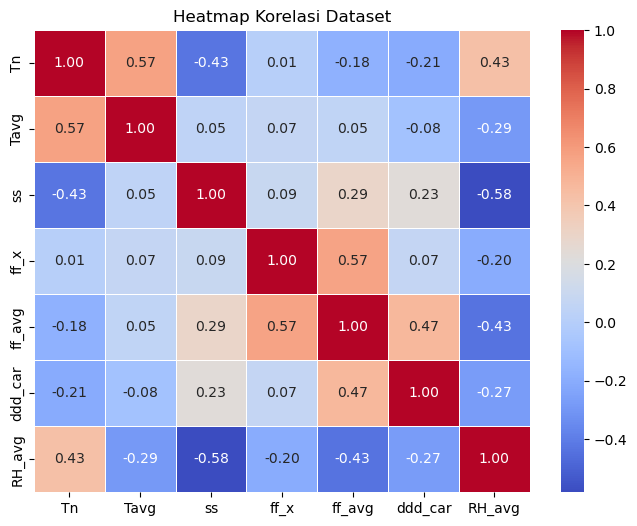

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = data.corr()

# Buat heatmap menggunakan seaborn
plt.figure(figsize=(8, 6))  # Atur ukuran heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Dataset")
plt.show()

### Uji Linearitas

In [100]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(data)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

  Variable         VIF
0    const  949.907655
1       Tn    3.672700
2     Tavg    3.168933
3       ss    1.634084
4     ff_x    1.618223
5   ff_avg    2.273528
6  ddd_car    1.433364
7   RH_avg    3.227222


### Uji Homoskedastisitas

In [115]:
from statsmodels.stats.diagnostic import het_breuschpagan
model = sm.OLS(data['RH_avg'],add_constant(data[['ss', 'Tn', 'Tavg']])).fit()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
stat, p_value, f_stat, f_p_value = bp_test
print(f"Breusch-Pagan Test Statistic: {stat}, p-value: {p_value}")

if p_value > 0.05:
    print("Homoskedastisitas terpenuhi.")
else:
    print("Homoskedastisitas tidak terpenuhi (heteroskedastisitas ada).")

Breusch-Pagan Test Statistic: 4.241792725874671, p-value: 0.23651080788735346
Homoskedastisitas terpenuhi.


## Gunakan Regresi Linier untuk Mencari Rumus Persamaan 

In [79]:
from sklearn.linear_model import LinearRegression

# Kelembapan rata-rata
X = data[['ss', 'Tn', 'Tavg']]     # Variabel independen
X = sm.add_constant(X)       # Tambahkan intersep
y = data['RH_avg']           # Variabel dependen     

# Buat model regresi linier
model1 = sm.OLS(y, X)
results1 = model1.fit()

# Hasil
print(results1.summary())

# Ambil koefisien
coefficients = results1.params
print("\nRumus untuk y1:")
print(f"y1 = {coefficients['const']} + {coefficients['ss']} * ss + {coefficients['Tn']} * Tn + {coefficients['Tavg']} * Tavg")


                            OLS Regression Results                            
Dep. Variable:                 RH_avg   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     170.1
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           3.37e-63
Time:                        23:30:43   Log-Likelihood:                -824.78
No. Observations:                 289   AIC:                             1658.
Df Residuals:                     285   BIC:                             1672.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.7510      5.539     19.094      0.0

In [73]:
X1 = data['ss'].values
X2 = data['Tn'].values
Z = data['Tavg'].values

y1 = coefficients['const'] + coefficients['ss'] * X1 + coefficients['Tn'] * X2 + coefficients['Tavg'] * Z

In [80]:
# Curah hujan
X = data[['ff_x','ddd_car', 'Tavg']]  # Variabel independen
X = sm.add_constant(X)       # Tambahkan intersep
y = data['ff_avg']                # Variabel dependen
      

# Buat model regresi linier
model2 = sm.OLS(y, X)
results2 = model2.fit()

# Hasil
print(results2.summary())

# Ambil koefisien
coefficients = results2.params
print("\nRumus untuk y2:")
print(f"y2 = {coefficients['const']} + {coefficients['ff_x']} * ff_x + {coefficients['ddd_car']} * ddd_car + {coefficients['Tavg']} * Tavg")

                            OLS Regression Results                            
Dep. Variable:                 ff_avg   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     106.5
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.88e-46
Time:                        23:30:52   Log-Likelihood:                -195.75
No. Observations:                 289   AIC:                             399.5
Df Residuals:                     285   BIC:                             414.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4291      0.541     -0.794      0.4

In [38]:
X3 = data['ff_x'].values
X4 = data['ddd_car'].values
Z = data['Tavg'].values

y2 = coefficients['const'] + coefficients['ff_x'] * X3 + coefficients['ddd_car'] * X4 + coefficients['Tavg'] * Z

## Estimasi SUR

In [82]:
df = pd.DataFrame({'y1': y1, 'X1': X1, 'X2': X2, 'Z': Z, 'y2': y2, 'X3': X3, 'X4':X4})

equations = {
    'eq1':'y1 ~ X1 + X2 + Z',  # First equation
    'eq2': 'y1 ~ X3 + X4 + Z'   # Second equation
}

# SUR Model
sur_model = SUR.from_formula(equations,df)
results = sur_model.fit()

## Interpretasi Hasil

In [83]:
# Hasil
print(results.summary)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.9917
No. Equations.:                     2   McElroy's R-squared:                -0.2249
No. Observations:                 289   Judge's (OLS) R-squared:            -0.6747
Date:                Fri, Nov 29 2024   Berndt's R-squared:                        
Time:                        23:31:27   Dhrymes's R-squared:                 0.9917
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                    Equation: eq1, Dependent Variable: y1                     
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X1            -0.1119     0.0931    -1.2026     0.2291     -0.2943      0.0705
X2          